<h1>Output Comparison</h1>

The following file can be used to compare any simulation runs no matter which settings have been used. To do so, one needs to provide the unique part of file path for each run in the file_extensions list. The notebook will then load the data and display the results for comparison for the four indicators:
1. Required Beds
2. Weekly Occupancy Rate
3. Capacity Transfer Rate
4. Weekly Capacity Transfers


<hr>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import sys
from itertools import product
pd.set_option('display.max_colwidth', None)

sns.set(style="whitegrid", palette="colorblind", font_scale=1.2)
sns.set_context("paper")
# Add the project folder to the Python path
project_path = os.path.abspath(os.path.join('..'))
if project_path not in sys.path:
    sys.path.append(project_path)
from model.config.run_config import *

import warnings
warnings.filterwarnings('ignore')


In [2]:
#list of file names
base_file_name = 'admission_log'
output_folder = '../model/outputs'

file_extensions = [  
    '_hospitalScenario_runs_25.csv',  
    '_hospitalScenario_phototherapyIntervention_runs_25.csv',

]

WARM_UP_TIME = 70

In [3]:
def read_files(base_file_name):
    data = []
    for extension in file_extensions:
        # Construct the full file path
        file_path = f"{output_folder}/{base_file_name}{extension}"
        print(f"Reading file: {file_path}")
        # Read the CSV file
        df = pd.read_csv(file_path)
        
        # Filter rows based on WARM_UP_TIME
        df = df[df['start_date'] >= WARM_UP_TIME]
        # Adjust start_date by subtracting warm-up time
        df['start_date'] = df['start_date'] - WARM_UP_TIME
        # Append the filtered DataFrame to the data list
        data.append(df)
        
    return data

In [4]:
admissions = read_files(base_file_name)

Reading file: ../model/outputs/admission_log_hospitalScenario_runs_25.csv
Reading file: ../model/outputs/admission_log_hospitalScenario_phototherapyIntervention_runs_25.csv


<h2>Required Bed Count</h2>

In [5]:
def process_admissions_data(df):
    # Filter the data to exclude 'Outside Region'
    df_inside = df[df['subregion'] != 'Outside Region']
    
    # Group by 'run_id' and 'ward' and calculate the sum of 'length_of_stay'
    result = df_inside.groupby(['run_id', 'ward'])['length_of_stay'].sum().reset_index()
    
    # Calculate 'used'
    result['used'] = result['length_of_stay'] / 365
    #number of outside region patients
    df_outside = df[(df['subregion'] == 'Outside Region')&(df['stay_number']==1)]
  
    
    # Group by 'ward' to calculate the mean of 'used'
    ward_mean_usage = result.groupby('ward').mean().reset_index()
    
    return ward_mean_usage

def aggregate_results(data_frames):
    all_results = []

    for i, df in enumerate(data_frames):
        ward_mean_usage = process_admissions_data(df)
        ward_mean_usage['file'] = i
        all_results.append(ward_mean_usage)

    # Concatenate all results into one DataFrame
    final_result = pd.concat(all_results)

    return final_result




final_usage = aggregate_results(admissions)
#drop run_id
final_usage = final_usage.drop(columns=['run_id'])


In [6]:

final_usage

,ward,length_of_stay,used,file
0,NICU,9842.84,26.966685,0
1,high,27417.00,75.115068,0
2,medium,12252.84,33.569425,0
0,NICU,9705.56,26.590575,1
1,high,27444.08,75.189260,1
2,medium,12054.84,33.026959,1


In [7]:
# Group by 'file' and calculate the sum for each group
totals = final_usage.groupby('file').sum().reset_index()



# Reorder the columns to match the original DataFrame
totals = totals[['ward', 'length_of_stay', 'used', 'file']]

# Append the totals to the original DataFrame
df_with_totals = pd.concat([final_usage, totals], ignore_index=True)

# Sort the DataFrame by 'file' to keep the rows together
df_with_totals = df_with_totals.sort_values(by='file').reset_index(drop=True)
df_with_totals

,ward,length_of_stay,used,file
0,NICU,9842.84,26.966685,0
1,high,27417.00,75.115068,0
2,medium,12252.84,33.569425,0
3,NICUhighmedium,49512.68,135.651178,0
4,NICU,9705.56,26.590575,1
5,high,27444.08,75.189260,1
6,medium,12054.84,33.026959,1
7,NICUhighmedium,49204.48,134.806795,1


In [8]:
#pivot table
pivot_table = df_with_totals.pivot(index='ward', columns='file', values='used')
pivot_table

file,0,1
ward,,
NICU,26.966685,26.590575
NICUhighmedium,135.651178,134.806795
high,75.115068,75.189260
medium,33.569425,33.026959


<h2>Capacity Transfer Rate </h2>

In [9]:
def filter_data_frames(data_frames):
    results = []
    for df in data_frames:
        df_outside = df[df['hospital'] == 'Outside Hospital']
        capacity_transfers = df_outside[df_outside['subregion'] != 'Outside Region']
        results.append(capacity_transfers)
    return results


filtered_data_frames = filter_data_frames(admissions)

In [10]:
def calculate_percentages(df, capacity_transfers):
    results = []
    for run in capacity_transfers['run_id'].unique():
        run_results = {'run_id': run}
        for ward in capacity_transfers[capacity_transfers['subregion'] != 'Outside Region']['ward'].unique():
            ward_df = df[(df['ward'] == ward) & (df['run_id'] == run)]
            if len(ward_df) > 0:  # Ensure there are entries in ward_df to avoid division by zero
                ward_group = capacity_transfers[capacity_transfers['run_id'] == run].groupby('ward').size()
                if ward in ward_group:
                    percentage = ward_group[ward] / len(ward_df) * 100
                else:
                    percentage = 0  # Handle case where ward is not in ward_group
            else:
                percentage = 0  # Handle case where ward_df is empty
            run_results[ward] = percentage
        results.append(run_results)
    return pd.DataFrame(results)

def process_data_frames(data_frames):
    summary_stats = []

    for i, df in enumerate(data_frames):        
        # Filter and process each DataFrame
        df_outside = df[df['hospital'] == 'Outside Hospital']
        capacity_transfers = df_outside[df_outside['subregion'] != 'Outside Region']
        results_df = calculate_percentages(df, capacity_transfers)

        # Extract min, mean, and max from descriptive statistics
        desc_stats = results_df.describe().loc[['min', 'mean', 'max']]
        desc_stats['DataFrame'] = i
        summary_stats.append(desc_stats)

    # Concatenate all the summary statistics into one table
    summary_table = pd.concat(summary_stats).reset_index().rename(columns={'index': 'Statistic'})

    return summary_table


summary_table = process_data_frames(admissions)


#only show mean
summary_table[summary_table['Statistic'] == 'mean']

,Statistic,run_id,high,NICU,medium,DataFrame
1,mean,13.0,20.464367,21.560137,0.045314,0
4,mean,13.0,20.132792,21.011533,0.014547,1


<h2>Occupancy Rate </h2>

In [11]:
base_file_name = 'occupancy_by_hospital'
occupancy_rates = read_files(base_file_name)


Reading file: ../model/outputs/occupancy_by_hospital_hospitalScenario_runs_25.csv
Reading file: ../model/outputs/occupancy_by_hospital_hospitalScenario_phototherapyIntervention_runs_25.csv


In [12]:
def process_occupancy_data(df_occupancy):    
    df_occupancy['start_date'] = df_occupancy['start_date'].astype(float)    
    # Calculate moving average and moving standard deviation per hospital and run
    df_occupancy['moving_average'] = df_occupancy.groupby(['hospital', 'run_id'])['occupancy'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
    df_occupancy['moving_std'] = df_occupancy.groupby(['hospital', 'run_id'])['occupancy'].transform(lambda x: x.rolling(window=7, min_periods=1).std())
    return df_occupancy

def compare_occupancy_by_ward_level(data_frames):
    comparison_stats = []

    for i, df in enumerate(data_frames):        
        df_occupancy = process_occupancy_data(df)
        # Calculate mean occupancy per ward level
        ward_level_stats = df_occupancy.groupby('ward_level').agg({'occupancy': 'mean'}).reset_index()
        # Add a column to identify the file index
        ward_level_stats['file'] = i        
        comparison_stats.append(ward_level_stats)

    # Concatenate all the comparison statistics into one table
    comparison_table = pd.concat(comparison_stats, ignore_index=True)
    # Pivot the table so that occupancy values are in columns based on ward_level, and file is used as an index
    comparison_table = comparison_table.pivot(index='file', columns='ward_level', values='occupancy').reset_index()
    # Rename the columns to remove the multi-level indexing
    comparison_table.columns.name = None

    return comparison_table


In [13]:
comparison_table = compare_occupancy_by_ward_level(occupancy_rates)

In [14]:
comparison_table

,file,NICU,high,medium
0,0,0.918024,0.972477,0.658435
1,1,0.913295,0.972236,0.649173


<h2>Weekly Transfers</h2>

In [15]:


def process_occupancy_data(df_occupancy, warm_up_time):
    # Convert start_date to float
    df_occupancy['start_date'] = df_occupancy['start_date'].astype(float)
    
    # Calculate moving average per hospital and run
    df_occupancy['moving_average'] = df_occupancy.groupby(['hospital', 'run_id'])['occupancy'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
    
    # Adjust start_date by subtracting warm-up time
    df_occupancy['date'] = df_occupancy['start_date'] 
    
    return df_occupancy

def merge_and_calculate(data_frames, occupancy_rates, warm_up_time):
    all_weekly_transfer = []

    for i, (df_transfers, df_occupancy) in enumerate(zip(data_frames, occupancy_rates)):
        # Process occupancy data
        df_occupancy = process_occupancy_data(df_occupancy, warm_up_time)

        # Aggregate transfer data
        transfer_agg = df_transfers.groupby(['run_id', 'start_date', 'ward']).size().reset_index(name='num_transfers')

        # Rename columns to match occupancy data for merging
        transfer_agg.rename(columns={'ward': 'ward_level', 'start_date': 'date'}, inplace=True)
        occupancy_agg = df_occupancy.groupby(['run_id', 'date', 'ward_level'], as_index=False).agg({'moving_average': 'mean'})

        # Set the minimum sample size threshold
        MIN_SAMPLE_SIZE = 10

        # Merge occupancy and transfer data
        occupancy_agg['run_id'] = occupancy_agg['run_id'].astype(int)
        transfer_agg['run_id'] = transfer_agg['run_id'].astype(int)
        merged_data = pd.merge(occupancy_agg, transfer_agg, how='left', on=['run_id', 'date', 'ward_level']).fillna({'num_transfers': 0})

        # Ensure 'num_transfers' is an integer
        merged_data['num_transfers'] = merged_data['num_transfers'].astype(int)

        # Group by and apply rolling window calculation within each group
        grouped = merged_data.groupby(['run_id', 'ward_level'])
        merged_data['transfer_count'] = grouped['num_transfers'].apply(lambda x: x.rolling(window=7, min_periods=1).sum()).reset_index(level=[0,1], drop=True)
        merged_data['transfer_count'].fillna(0, inplace=True)

        threshold_analysis = merged_data
        factor = 40
        threshold_analysis['moving_average_rounded'] = (threshold_analysis['moving_average'] * factor).round() / factor * 100

        # Calculate the weekly transfer for each occupancy rate and ward level
        weekly_transfer = threshold_analysis.groupby(['ward_level', 'moving_average_rounded']).apply(lambda x: x['transfer_count'].sum() / len(x)).reset_index(name='weekly_transfer')

        # Filter out occupancy rates with insufficient sample size
        sample_sizes = threshold_analysis.groupby(['ward_level', 'moving_average_rounded']).size().reset_index(name='sample_size')
        weekly_transfer = pd.merge(weekly_transfer, sample_sizes, on=['ward_level', 'moving_average_rounded'])
        weekly_transfer = weekly_transfer[weekly_transfer['sample_size'] >= MIN_SAMPLE_SIZE]

        # Drop the 'sample_size' column as it's no longer needed
        weekly_transfer = weekly_transfer.drop(columns=['sample_size'])

        # Add the file identifier
        weekly_transfer['file'] = i 

        all_weekly_transfer.append(weekly_transfer)

    # Concatenate all weekly transfer data
    final_weekly_transfer = pd.concat(all_weekly_transfer)

    return final_weekly_transfer

def create_weekly_transfer_table(final_weekly_transfer):
    # Pivot the table so that file identifiers are in a column and ward_level values are the column names
    weekly_transfer_table = final_weekly_transfer.pivot(index='file', columns='ward_level', values='weekly_transfer').reset_index()
    
    # Rename the columns to remove the multi-level indexing
    weekly_transfer_table.columns.name = None

    return weekly_transfer_table

# Assuming `filtered_data_frames` and `occupancy_rates` are defined
final_weekly_transfer = merge_and_calculate(filtered_data_frames, occupancy_rates, WARM_UP_TIME)
final_weekly_transfer.head(20)


,ward_level,moving_average_rounded,weekly_transfer,file
4,NICU,60.0,0.000000,0
5,NICU,62.5,0.000000,0
6,NICU,65.0,0.000000,0
7,NICU,67.5,0.000000,0
8,NICU,70.0,0.015385,0
9,NICU,72.5,0.040000,0
10,NICU,75.0,0.088435,0
11,NICU,77.5,0.148515,0
12,NICU,80.0,0.209302,0
13,NICU,82.5,0.391304,0


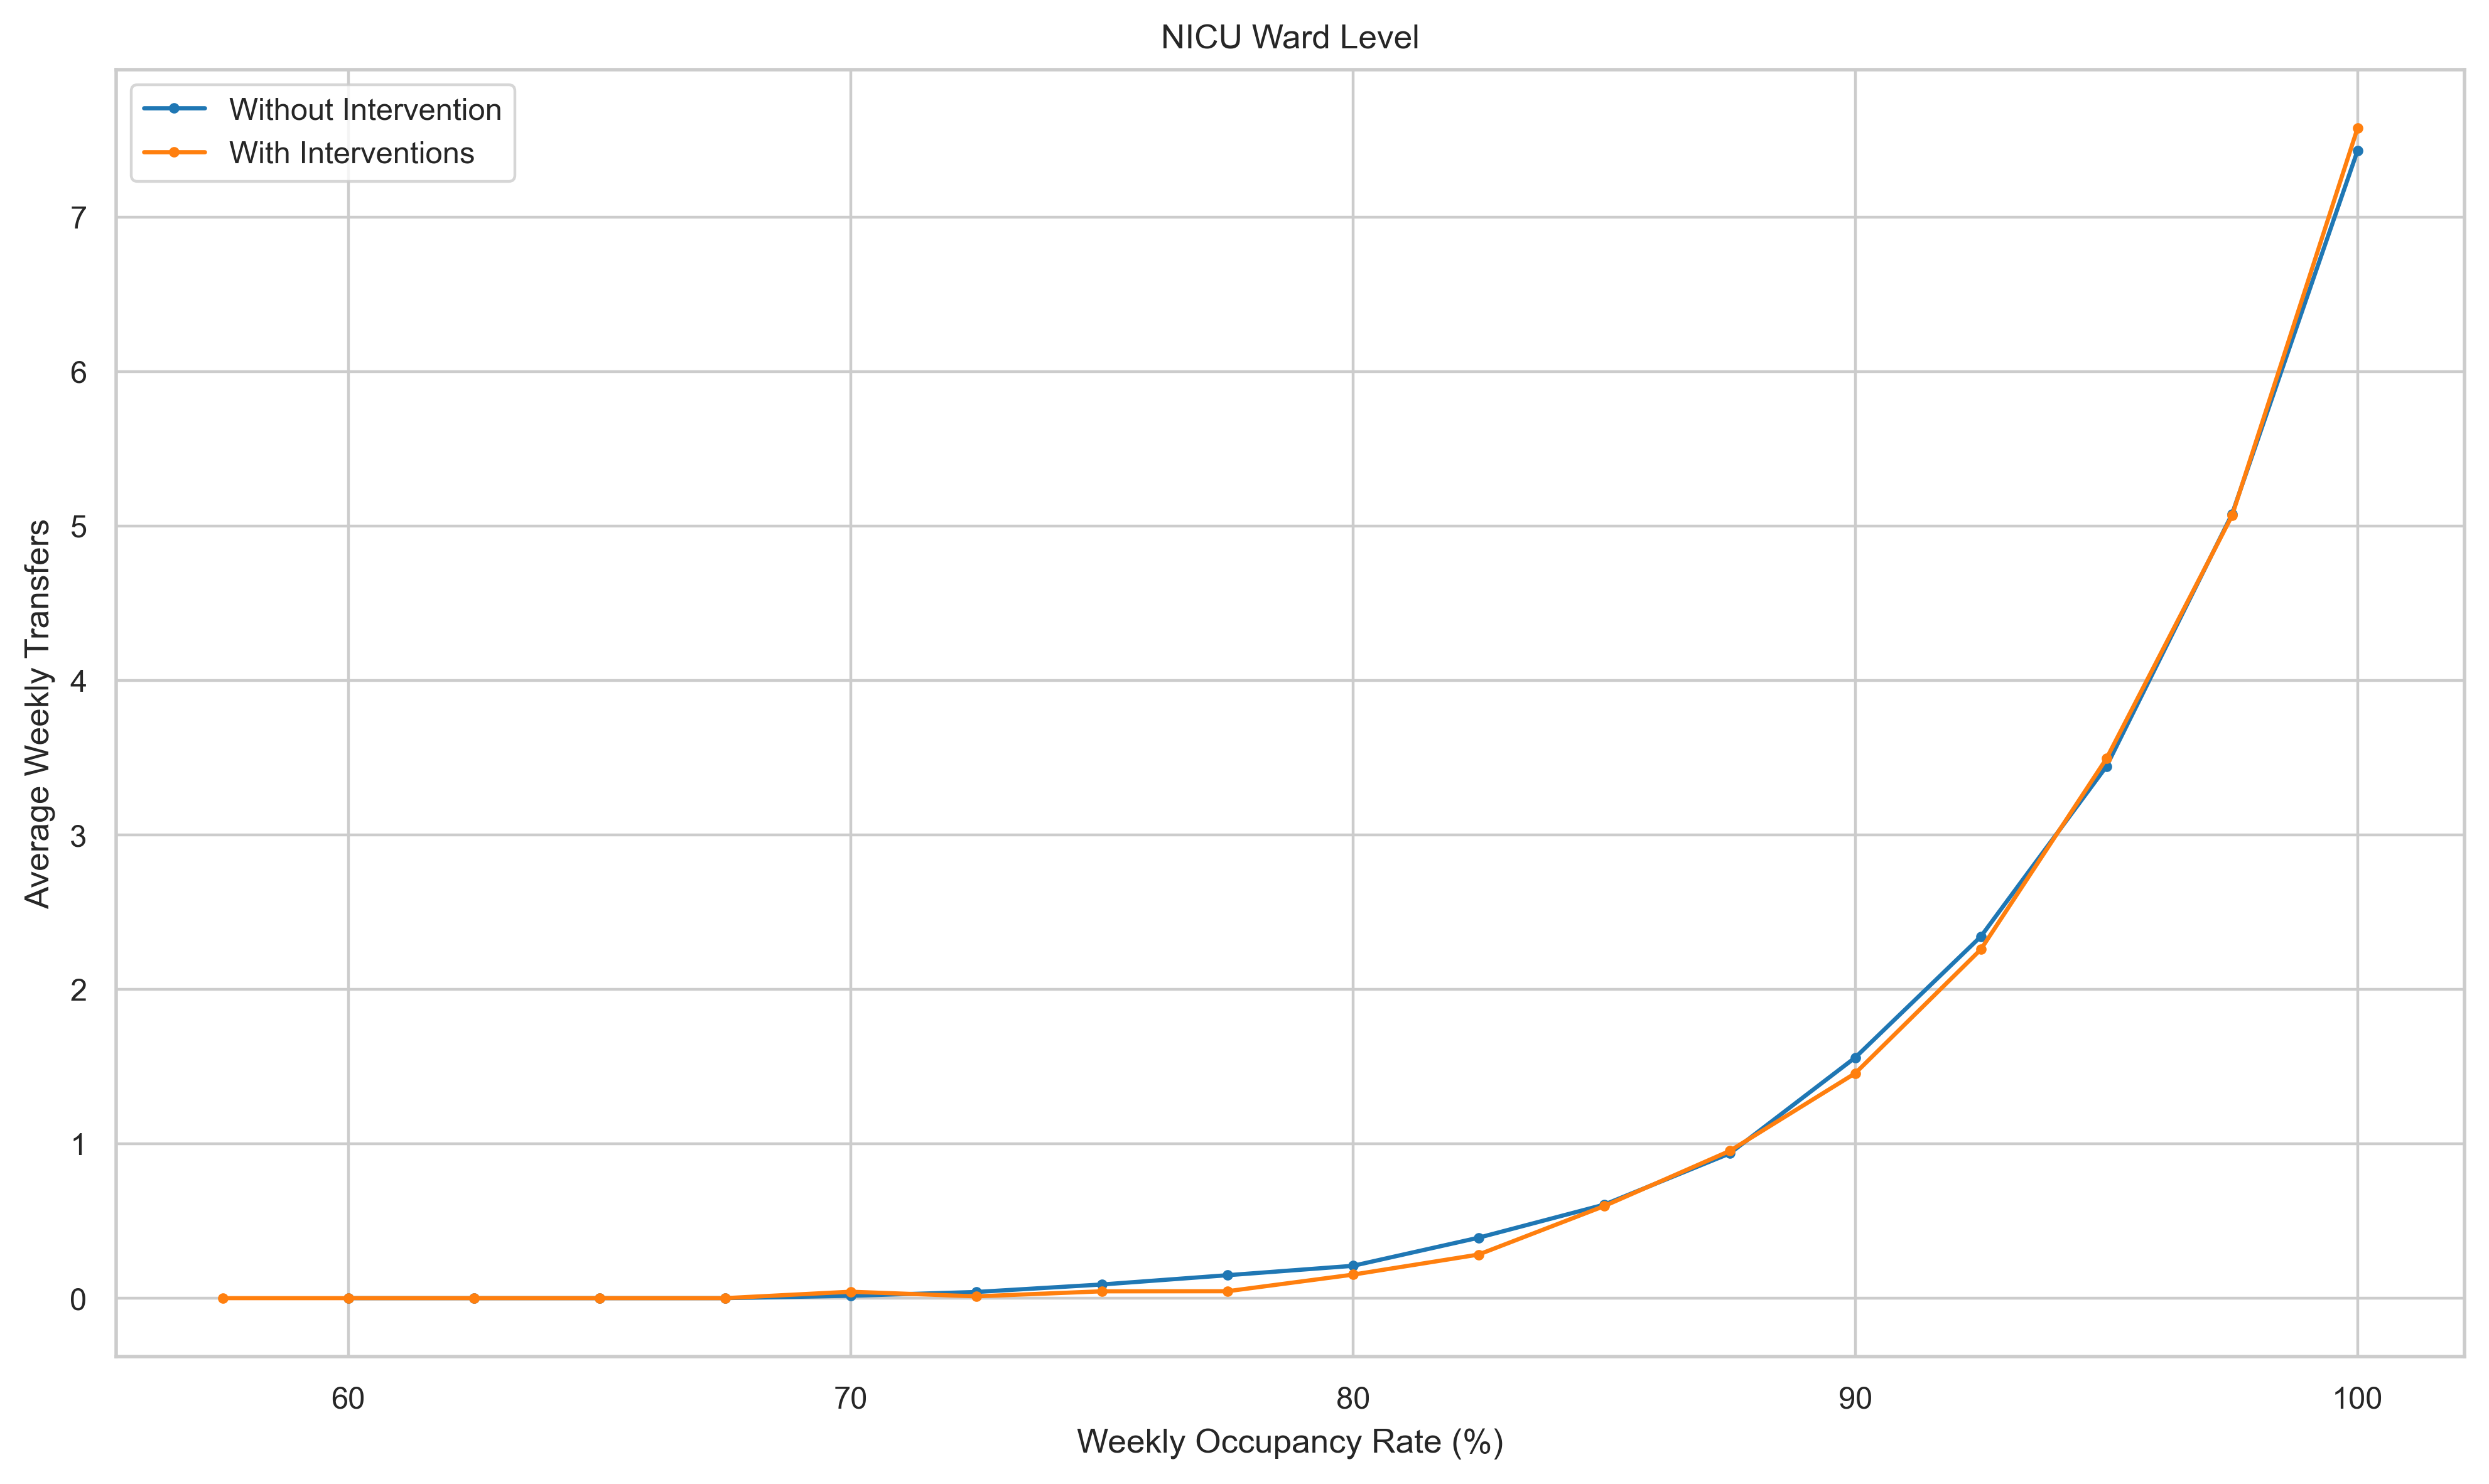

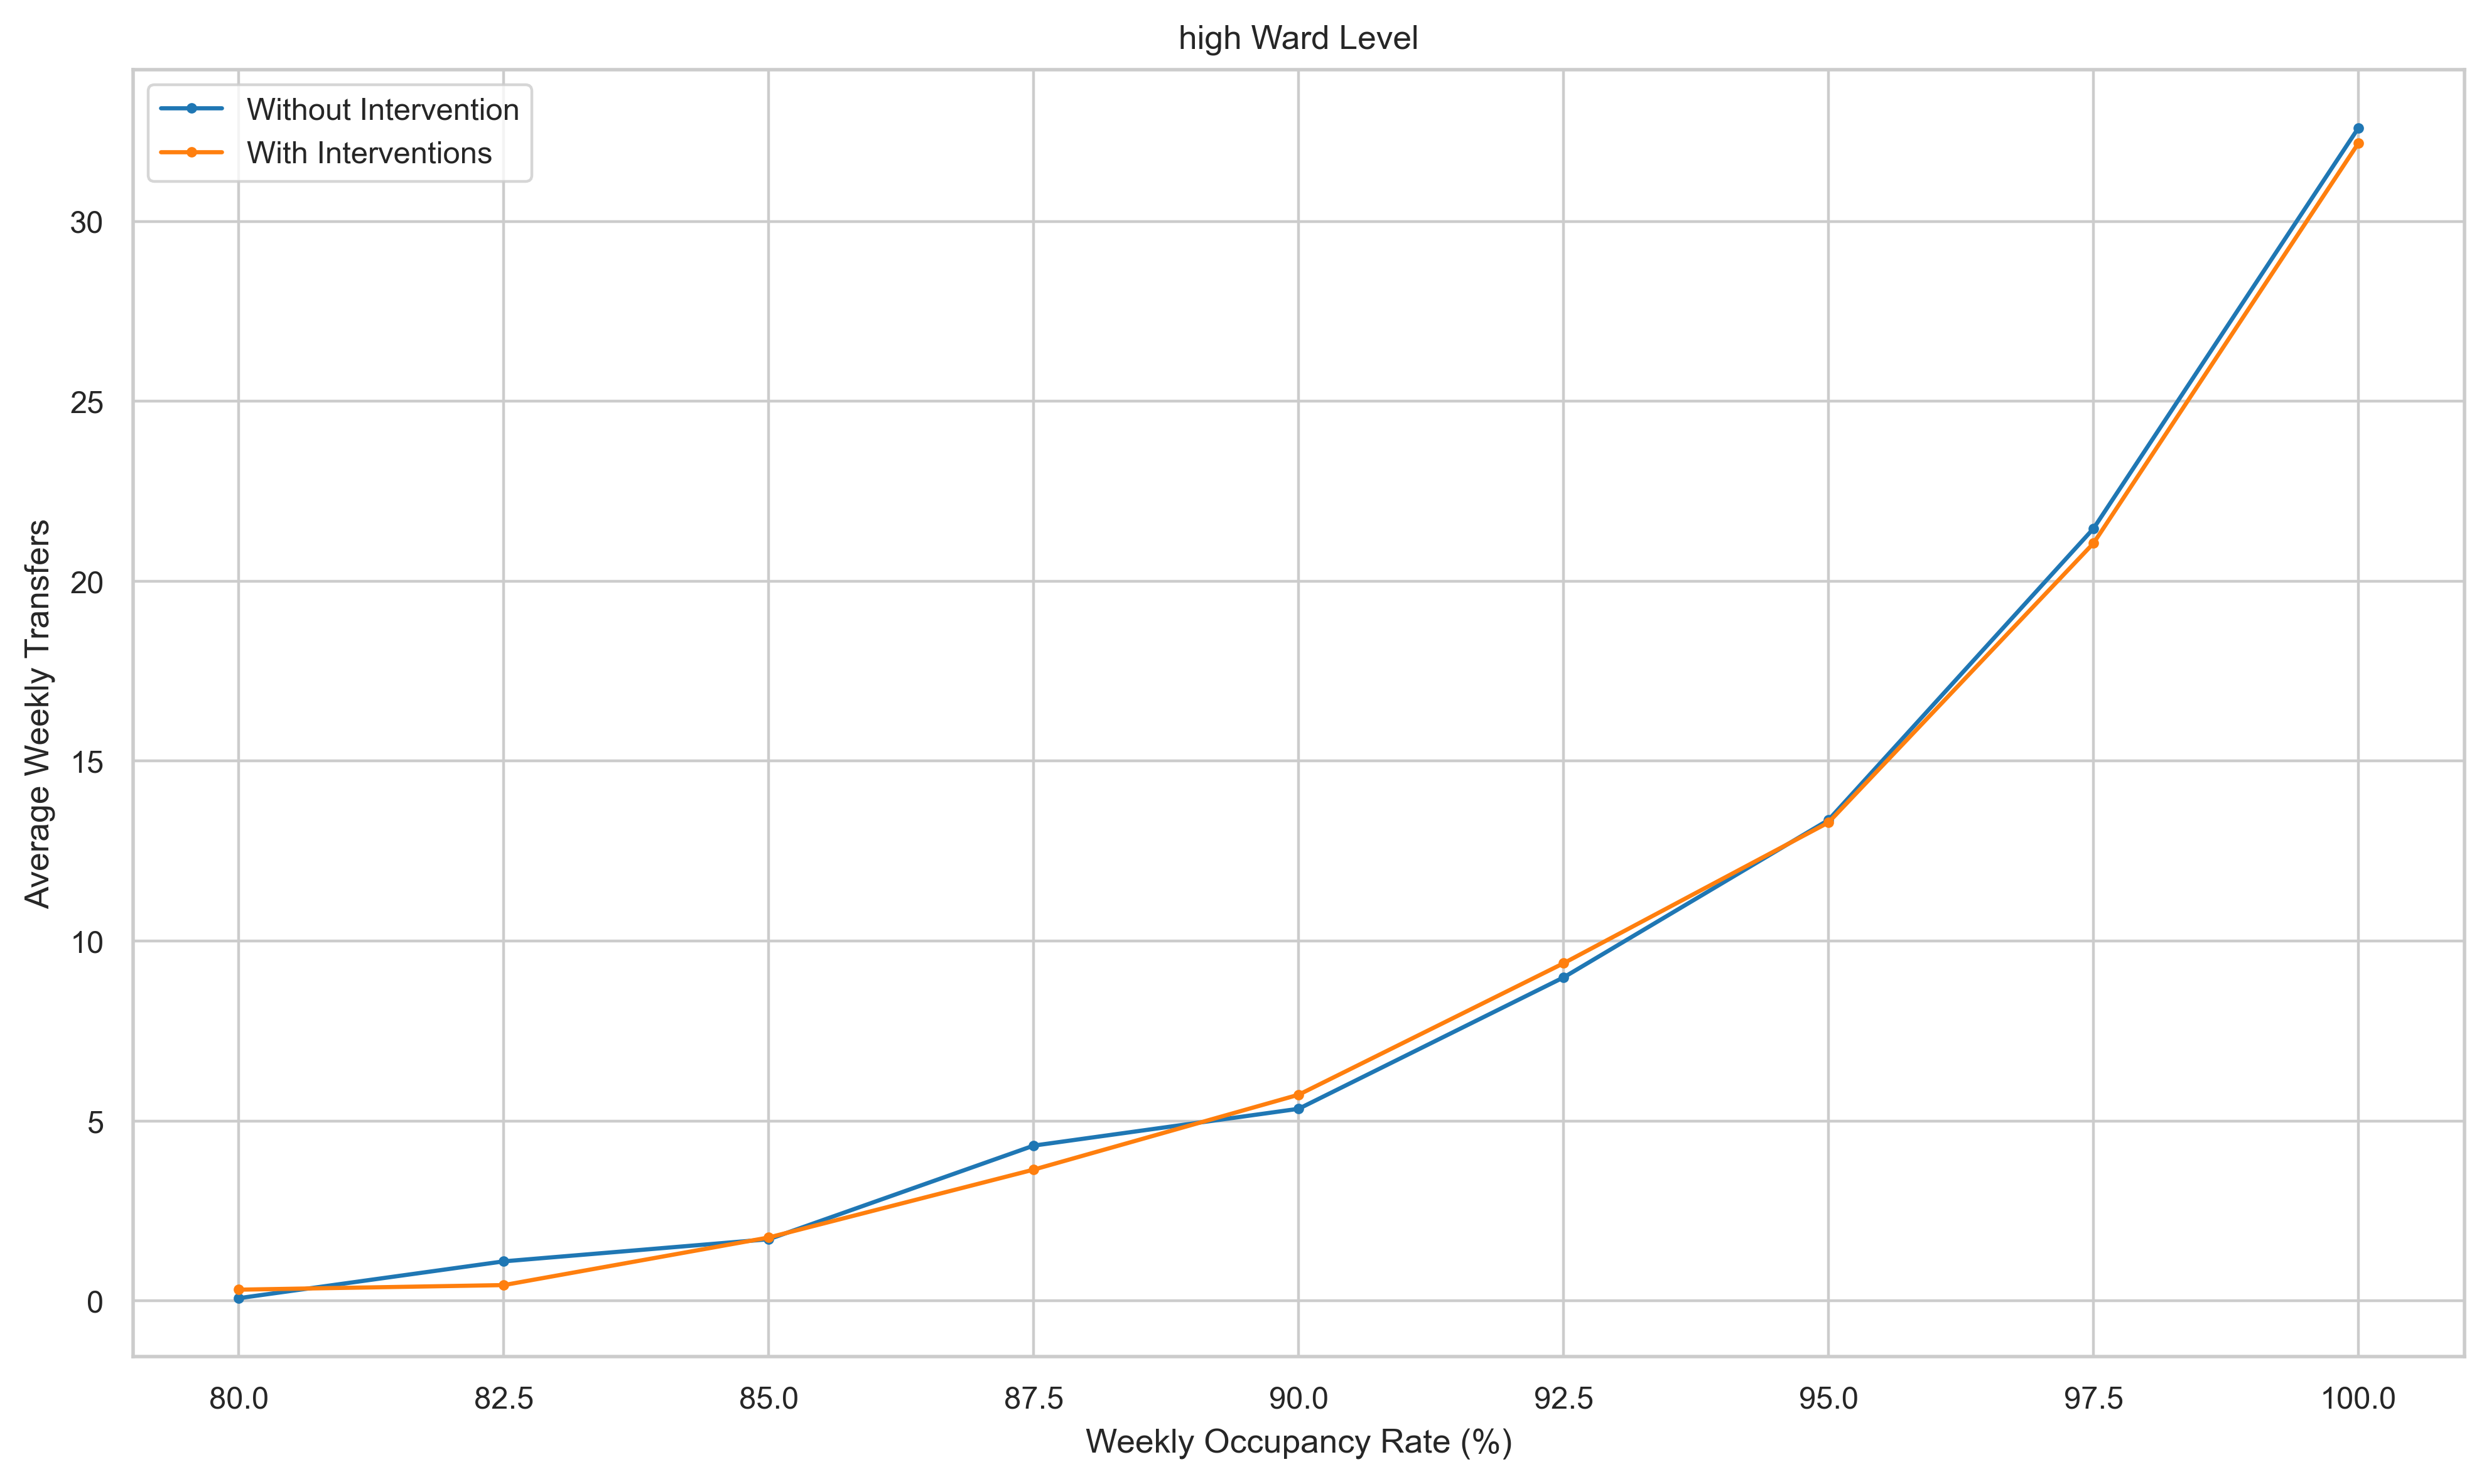

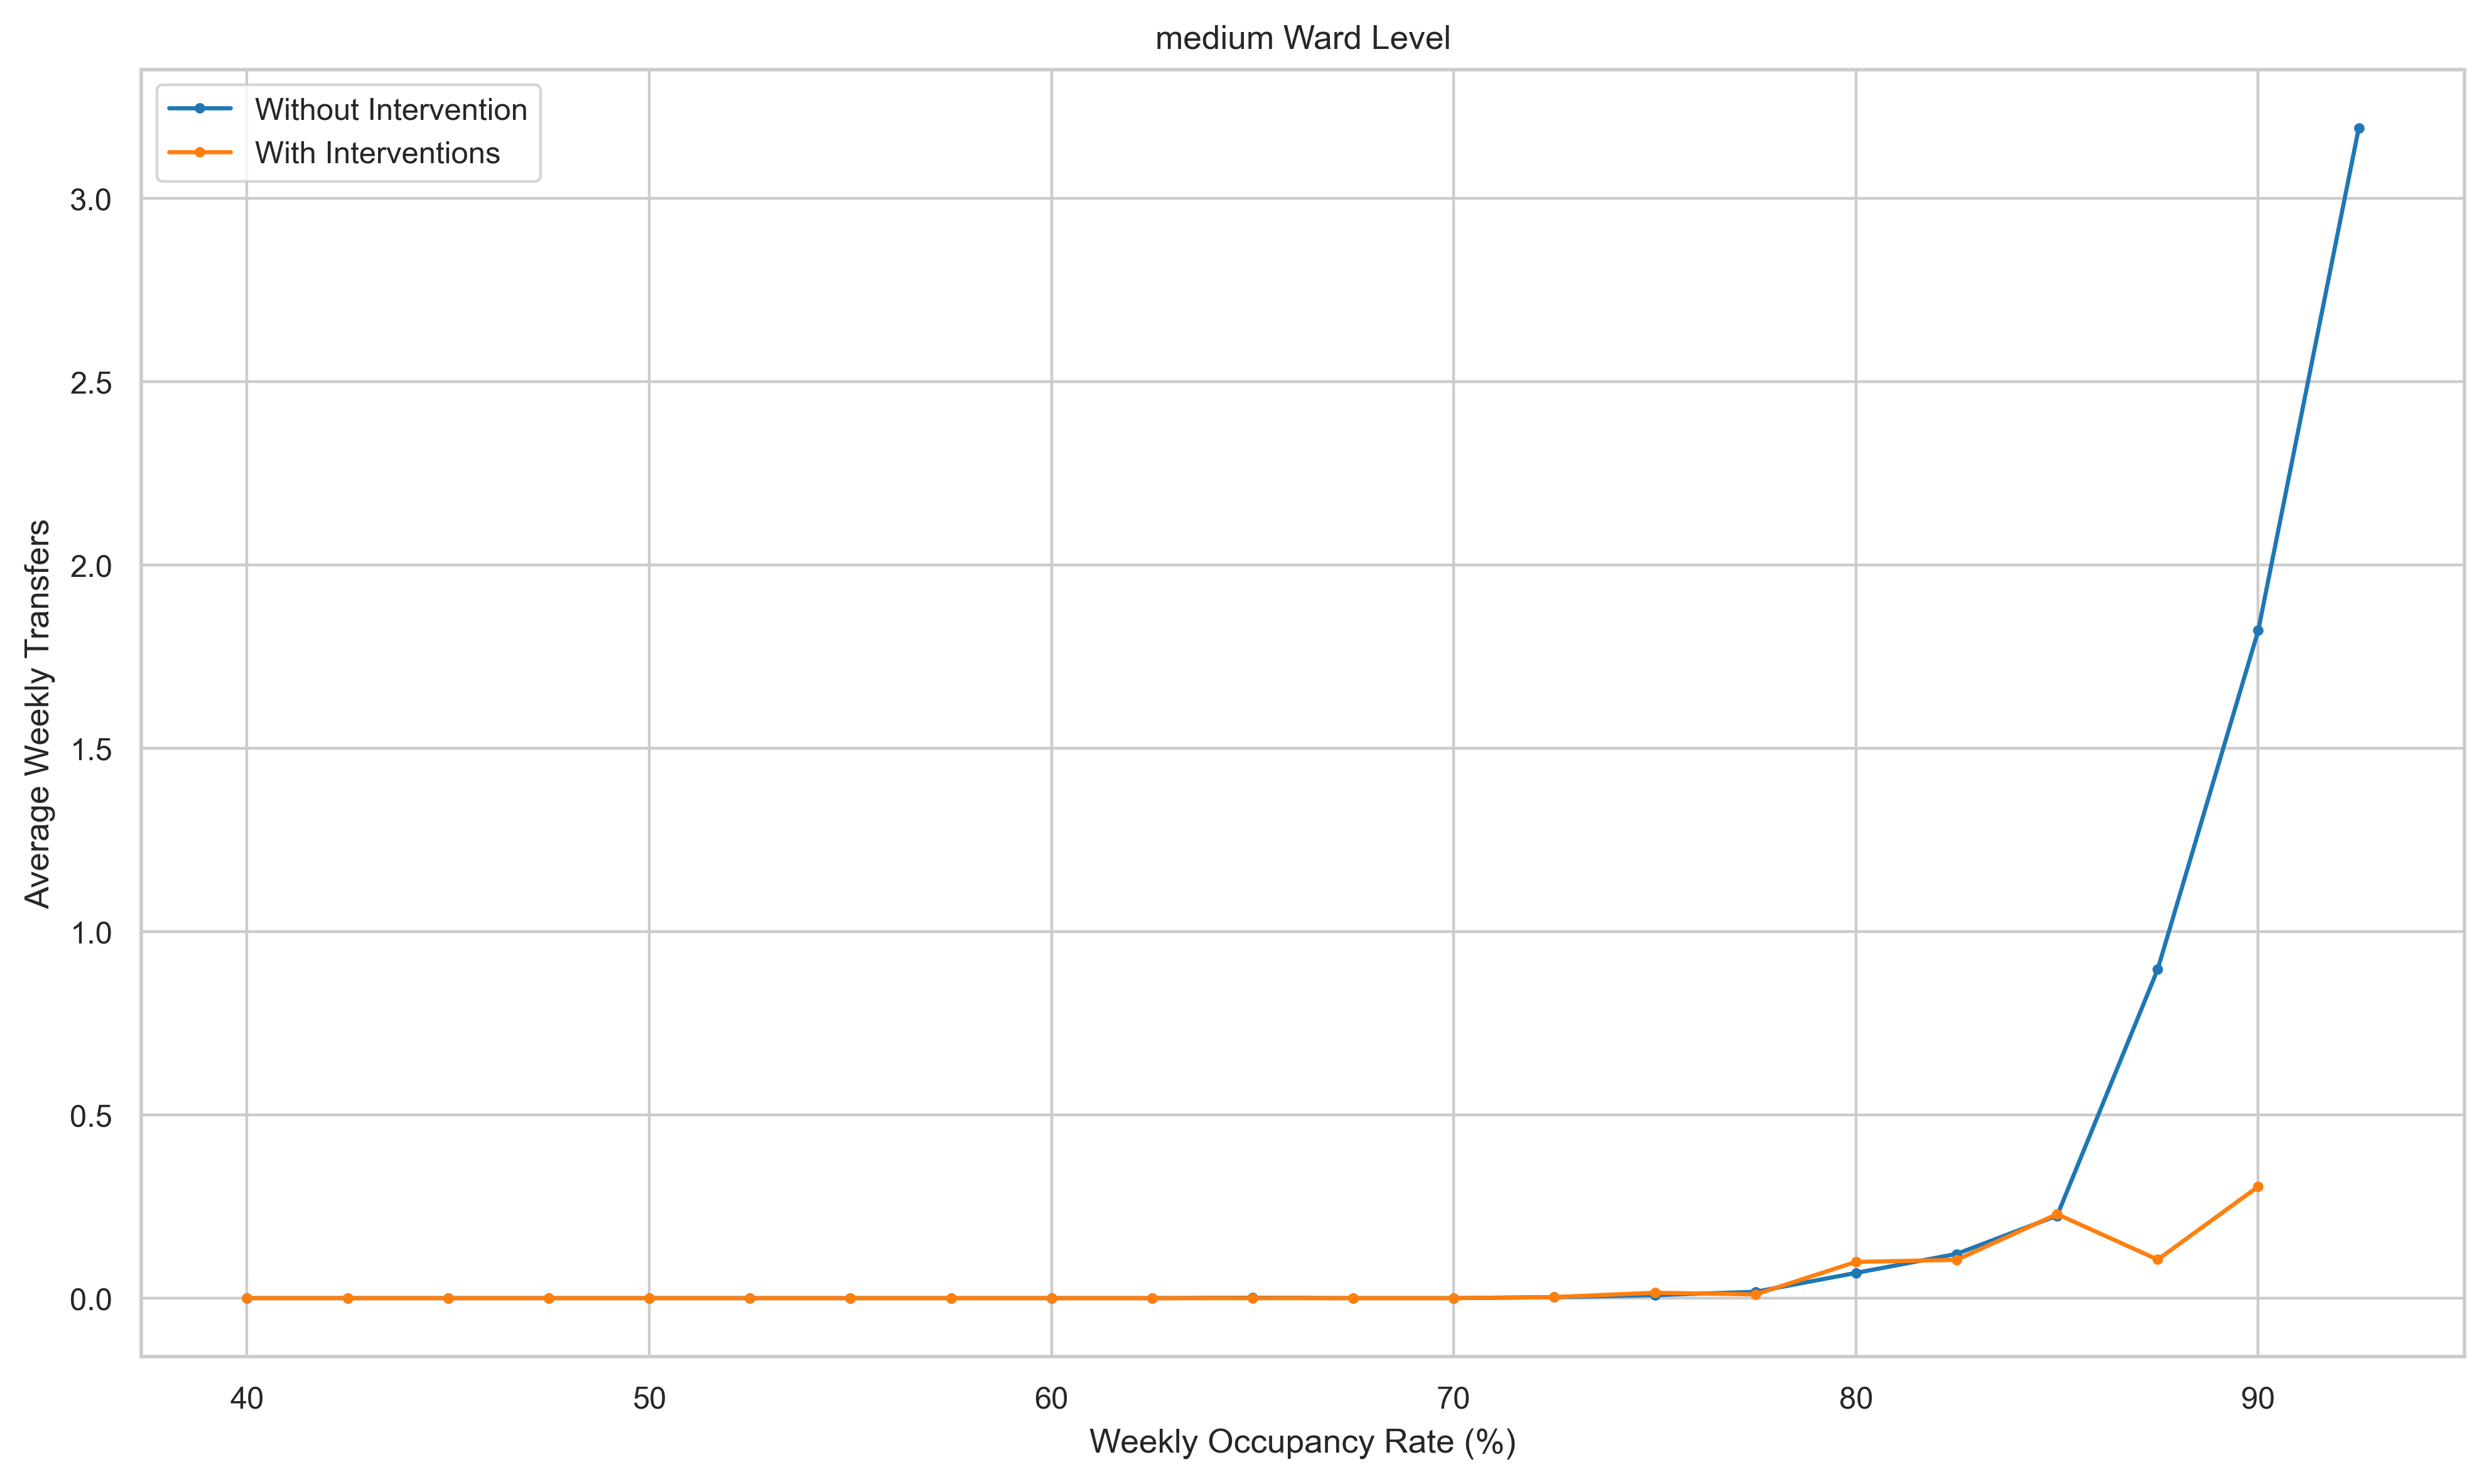

In [17]:
df = final_weekly_transfer

# Unique ward levels
ward_levels = df['ward_level'].unique()

# Create a color palette based on the number of unique files
palette = sns.color_palette("tab10", df['file'].nunique())

# Create a color map
color_map = {file_num: color for file_num, color in zip(df['file'].unique(), palette)}
#labels = ['Base Scenario', 'Capacity Shortage Scenario', 'Hospital Demand Scenario', 'NICU@23 Scenario']
labels = ['Without Intervention', 'With Interventions']
# Separate graphs for each ward level
for ward_level in ward_levels:
    subset = df[df['ward_level'] == ward_level]
    plt.figure(figsize=(10, 6), dpi=400)
    for file_num in subset['file'].unique():
        file_subset = subset[subset['file'] == file_num]
        plt.plot(file_subset['moving_average_rounded'], file_subset['weekly_transfer'], 
                 marker='o', markersize=2, label=labels[file_num], color=color_map[file_num])
    plt.title(f'{ward_level} Ward Level')
    plt.xlabel('Weekly Occupancy Rate (%)')
    plt.ylabel('Average Weekly Transfers')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
